## Importing the necessary libraries & loading the dataset

In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

dataset_pathname = 'drive/MyDrive/dataset.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading the dataset

In [52]:
df = pd.read_excel(dataset_pathname)
df.head()

,person_name,event_ts,location
0,7_1_0032247,2024-08-28 13:22:50.781355+00,"['25.268293, 55.297596']"
1,3_3_0105341,2024-08-28 13:22:36.407468+00,"['25.268017, 55.297518']"
2,3_3_0103424,2024-08-28 13:22:39.372381+00,"['25.271235, 55.301078']"
3,4_3_0114500,2024-08-28 13:23:00.928218+00,"['25.267324, 55.29629']"
4,9_2_0073534,2024-08-28 13:25:31.105655+00,"['25.271488, 55.305731']"


## Processing person_name column

In [53]:
df = df[[row['person_name'][0].isdigit() for index, row in df.iterrows()]]

repetitions = df['person_name'].value_counts()
df = df[df['person_name'].isin(repetitions[repetitions > 10].index)]

id_offset = 100
person_id_mapping = {person_id: (i+1) * id_offset for i, person_id in enumerate(df['person_name'].unique())}
df['person_id'] = df['person_name'].map(person_id_mapping)

print(df)

         person_name                       event_ts  \
1        3_3_0105341  2024-08-28 13:22:36.407468+00   
3        4_3_0114500  2024-08-28 13:23:00.928218+00   
8        5_4_0133360  2024-08-28 13:25:07.715962+00   
9        6_2_0063919  2024-08-28 13:24:50.050432+00   
10       4_0_0004856  2024-08-28 13:24:58.409205+00   
...              ...                            ...   
1048565  7_2_0087470  2024-08-02 14:22:12.115407+00   
1048567  0_4_0147563  2024-08-02 14:22:33.476957+00   
1048568  3_1_0057163  2024-08-02 14:24:16.419702+00   
1048569  2_0_0003529  2024-08-02 14:24:29.301376+00   
1048574  3_5_0178908  2024-08-02 14:28:08.351395+00   

                             location  person_id  
1            ['25.268017, 55.297518']        100  
3             ['25.267324, 55.29629']        200  
8        ['25.27135433, 55.30545345']        300  
9            ['25.271341, 55.301739']        400  
10           ['25.271352, 55.302019']        500  
...                              

<ipython-input-53-116869f312f1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['person_id'] = df['person_name'].map(person_id_mapping)


## Formatting event_ts *column*

In [54]:
event_date = df['event_ts'].str.split(" ", expand=True)[0]
df[['year', "month", "day"]] = event_date.str.split("-", expand=True).apply(pd.to_numeric)

event_timestamp = df['event_ts'].str.split(" ", expand=True)[1]
event_time = event_timestamp.str.split('+', expand=True)[0]

df[['hours', 'minutes', 'seconds']] = event_time.str.split(":", expand=True).apply(pd.to_numeric)
df['time_zone'] = event_timestamp.str.split('+', expand=True)[1].apply(pd.to_numeric)

print(df)

         person_name                       event_ts  \
1        3_3_0105341  2024-08-28 13:22:36.407468+00   
3        4_3_0114500  2024-08-28 13:23:00.928218+00   
8        5_4_0133360  2024-08-28 13:25:07.715962+00   
9        6_2_0063919  2024-08-28 13:24:50.050432+00   
10       4_0_0004856  2024-08-28 13:24:58.409205+00   
...              ...                            ...   
1048565  7_2_0087470  2024-08-02 14:22:12.115407+00   
1048567  0_4_0147563  2024-08-02 14:22:33.476957+00   
1048568  3_1_0057163  2024-08-02 14:24:16.419702+00   
1048569  2_0_0003529  2024-08-02 14:24:29.301376+00   
1048574  3_5_0178908  2024-08-02 14:28:08.351395+00   

                             location  person_id  year  month  day  hours  \
1            ['25.268017, 55.297518']        100  2024      8   28     13   
3             ['25.267324, 55.29629']        200  2024      8   28     13   
8        ['25.27135433, 55.30545345']        300  2024      8   28     13   
9            ['25.271341, 55.30

## Formatting location column

In [55]:
latitude = df['location'].str.split(', ', expand=True)[0]
longitude = df['location'].str.split(', ', expand=True)[1]

df['latitude'] = latitude.str[2:].apply(pd.to_numeric)
df['longitude'] = longitude.str[:-2].apply(pd.to_numeric)

print(df)

         person_name                       event_ts  \
1        3_3_0105341  2024-08-28 13:22:36.407468+00   
3        4_3_0114500  2024-08-28 13:23:00.928218+00   
8        5_4_0133360  2024-08-28 13:25:07.715962+00   
9        6_2_0063919  2024-08-28 13:24:50.050432+00   
10       4_0_0004856  2024-08-28 13:24:58.409205+00   
...              ...                            ...   
1048565  7_2_0087470  2024-08-02 14:22:12.115407+00   
1048567  0_4_0147563  2024-08-02 14:22:33.476957+00   
1048568  3_1_0057163  2024-08-02 14:24:16.419702+00   
1048569  2_0_0003529  2024-08-02 14:24:29.301376+00   
1048574  3_5_0178908  2024-08-02 14:28:08.351395+00   

                             location  person_id  year  month  day  hours  \
1            ['25.268017, 55.297518']        100  2024      8   28     13   
3             ['25.267324, 55.29629']        200  2024      8   28     13   
8        ['25.27135433, 55.30545345']        300  2024      8   28     13   
9            ['25.271341, 55.30

## Dropping unneeded columns

#### **After some exploration for the dataset we noticed that**

- The ``year`` and the ``time_zone`` columns have the same value in all rows so we decided to not include them in the processed dataset
- The ``minutes`` column is also no crucial for our use case
- The ``seconds`` columns has so many values, is easily prone to errors and is not a key factor for our desired result so we will get rid of it as well

In [56]:
df.nunique()

,0
person_name,17824
event_ts,489830
location,85
person_id,17824
year,1
month,3
day,8
hours,24
minutes,60
seconds,487856


In [57]:
columns_to_drop = df.filter(regex="event_ts|location|person_name|year|time_zone|seconds|minutes", axis=1)
df = df.drop(columns_to_drop.columns, axis=1)

## Assuring no null values exist in the dataset

In [58]:
df.dropna(inplace=True)

print(df)

         person_id  month  day  hours   latitude  longitude
1              100      8   28     13  25.268017  55.297518
3              200      8   28     13  25.267324  55.296290
8              300      8   28     13  25.271354  55.305453
9              400      8   28     13  25.271341  55.301739
10             500      8   28     13  25.271352  55.302019
...            ...    ...  ...    ...        ...        ...
1048565      94300      8    2     14  25.268471  55.296825
1048567    1708100      8    2     14  25.270839  55.297978
1048568     699500      8    2     14  25.270839  55.297978
1048569     324700      8    2     14  25.267324  55.296290
1048574     881000      8    2     14  25.270983  55.298039

[489831 rows x 6 columns]


## Normalizing the data

In [59]:
def normalize(data):
  min = data.min()
  max = data.max()

  return (data - min) / (max - min)

for col in df.columns:
  df[col] = normalize(df[col])

print(df)

         person_id  month       day     hours  latitude  longitude
1         0.000000    0.5  0.900000  0.565217  0.158442   0.144030
3         0.000056    0.5  0.900000  0.565217  0.030916   0.034446
8         0.000112    0.5  0.900000  0.565217  0.772583   0.852173
9         0.000168    0.5  0.900000  0.565217  0.770130   0.520703
10        0.000224    0.5  0.900000  0.565217  0.772154   0.545690
...            ...    ...       ...       ...       ...        ...
1048565   0.052853    0.5  0.033333  0.608696  0.241988   0.082188
1048567   0.958312    0.5  0.033333  0.608696  0.677751   0.185079
1048568   0.392414    0.5  0.033333  0.608696  0.677751   0.185079
1048569   0.182124    0.5  0.033333  0.608696  0.030916   0.034446
1048574   0.494249    0.5  0.033333  0.608696  0.704250   0.190523

[489831 rows x 6 columns]



## Clustering latitude and longitude

By plotting the relation between latitude and longitude we notice that we can cluster them into locations for more accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Data after clustering')

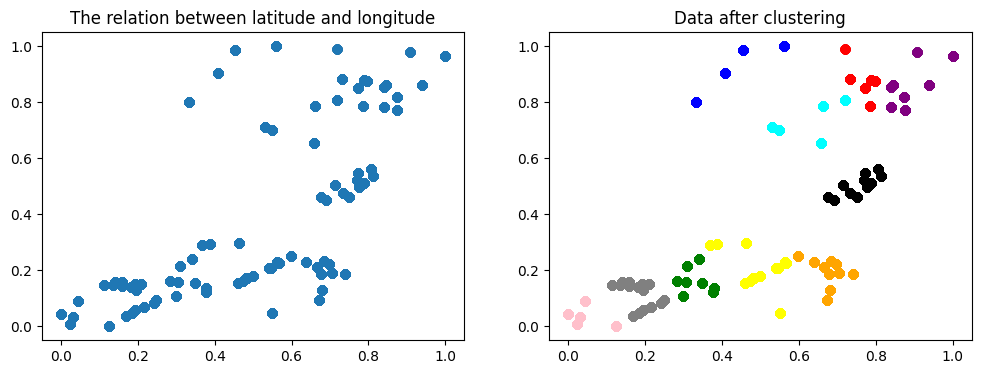

In [60]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
axs[0].scatter(df['latitude'], df['longitude'])
axs[0].set_title('The relation between latitude and longitude')

n_clusters = 10
cluster = KMeans(n_clusters)
location_cluster = cluster.fit_predict(df[['latitude', 'longitude']])

df['location_cluster'] = location_cluster

colors = ['red', 'green', 'black', 'orange', 'blue', 'gray', 'cyan', 'pink', 'purple', 'yellow']

for i in range(0, n_clusters):
  df_plot = df[df['location_cluster'] == i]
  axs[1].scatter(df_plot['latitude'], df_plot['longitude'], color=colors[i])

axs[1].set_title('Data after clustering')

## Normalizing the location_cluster column
Transforming the ``location_cluster`` to a form suitable for machine learning and dropping the ``latitude`` and ``longitude`` columns

In [61]:
df['location_cluster'] = normalize(df['location_cluster'])
df = df.drop(df[['latitude', 'longitude']], axis=1)

print(df)

         person_id  month       day     hours  location_cluster
1         0.000000    0.5  0.900000  0.565217          0.555556
3         0.000056    0.5  0.900000  0.565217          0.777778
8         0.000112    0.5  0.900000  0.565217          0.000000
9         0.000168    0.5  0.900000  0.565217          0.222222
10        0.000224    0.5  0.900000  0.565217          0.222222
...            ...    ...       ...       ...               ...
1048565   0.052853    0.5  0.033333  0.608696          0.555556
1048567   0.958312    0.5  0.033333  0.608696          0.333333
1048568   0.392414    0.5  0.033333  0.608696          0.333333
1048569   0.182124    0.5  0.033333  0.608696          0.777778
1048574   0.494249    0.5  0.033333  0.608696          0.333333

[489831 rows x 5 columns]


## writing the result in an excel file

In [62]:
df.to_excel(r'./processed-dataset.xlsx', index=None)